# Environment setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install simpletransformers &> /dev/null
! pip install odfpy &> /dev/null

# Latex for output
! apt install texlive-latex-recommended -qq &> /dev/null
! apt install texlive-latex-extra -qq &> /dev/null
! apt install dvipng -qq &> /dev/null
! apt install cm-super -qq &> /dev/null

# Load repository

!git clone https://github.com/dafrie/fin-disclosures-nlp.git &> /dev/null
%cd /content/fin-disclosures-nlp

/content/fin-disclosures-nlp


In [3]:
import os

from simpletransformers.classification import (
    ClassificationModel, ClassificationArgs, 
)
import numpy as np
import pandas as pd
import sklearn
import logging

from data import evaluation

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Config

## Task setup

In [4]:
class Params:
  TASK = "binary" #@param ["binary"]
  CATEGORY_LEVEL = 'cro_sub_type' #@param ["cro", "cro_sub_type"]
  SCENARIO = "realistic" #@param [ "optimistic", "realistic"]

  # Evaluation metric config. See for context: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
  AVERAGING_STRATEGY = 'macro' #@param ["micro",  "macro", "weighted"]

  RESULTS_FILE_NAME = f"{CATEGORY_LEVEL}_{TASK}_results.csv"

  # To make the notebook reproducible (not guaranteed for pytorch on different releases/platforms!)
  SEED_VALUE = 4200

params = Params()

## Model setup

In [5]:
# See list here: https://huggingface.co/models
params.MODEL_TYPE  = 'roberta' #@param ["bert", "distilbert", "albert", "roberta", "xlmroberta", "xlnet"]
params.MODEL_NAME = 'roberta-large' #@param ["bert-base-uncased", "bert-large-uncased", "albert-base-v2", "albert-large-v2", "albert-xlarge-v2", "albert-xxlarge-v2", "roberta-base", "roberta-large", "distilbert-base-uncased", "distilbert-base-cased", "xlnet-base-cased", "xlnet-large-cased"]
params.model_name = params.MODEL_NAME


# Learning params
params.ENABLE_FINETUNING = True #@param {type:"boolean"}
params.SHOULD_HYPERPARAMETER_SEARCH = False #@param {type:"boolean"}

# The DataLoader needs to know our batch size for training. BERT Authors recommend 16 or 32, however this leads to an error due to not enough GPU memory
params.BATCH_SIZE = 16 #@param ["8", "16", "32"] {type:"raw"}
#parameters['max_token_size'] = 256 #@param [512,256,128] {type:"raw"}
params.EPOCHS = 4 # @param [1,2,3,4, 5, 6, 10, 20, 30, 40] {type:"raw"}
#parameters['learning_rate'] = 2e-5
#parameters['weight_decay'] = 0

## Data setup

In [6]:
params.scenario = params.SCENARIO
params.DIR = "/content/drive/MyDrive/fin-disclosures-nlp"
params.DATA_DIR = os.path.join(params.DIR, "data", "labels")
params.MODELS_DIR = os.path.join(params.DIR, "models", params.MODEL_TYPE)
params.RESULTS_DIR = os.path.join(params.DIR, 'results')
params.RESULTS_FILE_PATH = os.path.join(params.RESULTS_DIR, params.RESULTS_FILE_NAME)

# Setup

In [7]:
# Load/Initialize results file
results = evaluation.Results(params.RESULTS_FILE_PATH, vars(params))

## Data loading

In [8]:
CATEGORY_CODES = ["ACUTE", "CHRON", "POLICY", "MARKET", "REPUT"]

train_df = pd.read_csv(os.path.join(params.DATA_DIR, f"train_explicit.csv"))
train_df = train_df.sample(frac=1, random_state=params.SEED_VALUE)

train_df["IS_RISK"] = train_df[CATEGORY_CODES].any(axis=1)
train_text = train_df.text
train_labels = train_df["IS_RISK"]

In [9]:
valid_df = pd.read_csv(os.path.join(params.DATA_DIR, f"valid_{params.SCENARIO}.csv"))
valid_df = valid_df.sample(frac=1, random_state=params.SEED_VALUE)

test_df = pd.read_csv(os.path.join(params.DATA_DIR, f"test_{params.SCENARIO}.csv"))
test_df = test_df.sample(frac=1, random_state=params.SEED_VALUE)

valid_df["IS_RISK"] = valid_df[CATEGORY_CODES].any(axis=1)
test_df["IS_RISK"] = test_df[CATEGORY_CODES].any(axis=1)

valid_text = valid_df.text
valid_labels = valid_df["IS_RISK"]

test_text = test_df.text
test_labels = test_df["IS_RISK"]

In [10]:
train_df = pd.DataFrame(data={ 'text': train_text, 'labels': train_labels.to_numpy().tolist() })
valid_df = pd.DataFrame(data={ 'text': valid_text, 'labels': valid_labels.to_numpy().tolist() })
test_df = pd.DataFrame(data={ 'text': test_text, 'labels': test_labels.to_numpy().tolist() })

## Calculate positive weights

In [11]:
# def get_pos_weights(labels):
#   """Calculates weights for each class that relates to the ratio of positive to negative sample in each class"""
#   pos_counts = np.sum(labels, axis=0)
#   neg_counts = [len(labels) - pos_count for pos_count in pos_counts]
#   pos_weights = neg_counts / pos_counts
#   return pos_weights.to_list()

# pos_weights = get_pos_weights(train_labels)

# Model initialization

In [12]:
model_id = params.SCENARIO + "_" + params.MODEL_NAME + "_" + params.CATEGORY_LEVEL
print(f"Selected {params.MODEL_NAME} as transformer model for the task to classification of {params.CATEGORY_LEVEL}...")

# Config: https://simpletransformers.ai/docs/usage/
model_args = ClassificationArgs(
    num_train_epochs=params.EPOCHS, 
    best_model_dir=os.path.join(params.MODELS_DIR, params.TASK, model_id),
    manual_seed=params.SEED_VALUE,
    train_batch_size=params.BATCH_SIZE,
    use_early_stopping=True,
    # early_stopping_metric="...".
    # early_stopping_metric_minimize
)

# Model
model = ClassificationModel(
    params.MODEL_TYPE,
    params.MODEL_NAME,
    args=model_args,
    #pos_weight=pos_weights,
)

Selected roberta-large as transformer model for the task to classification of cro_sub_type...


INFO:filelock:Lock 140028684003216 acquired on /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373.lock


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

INFO:filelock:Lock 140028684003216 released on /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373.lock
INFO:filelock:Lock 140028626324112 acquired on /root/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352.lock


Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

INFO:filelock:Lock 140028626324112 released on /root/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352.lock
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

INFO:filelock:Lock 140028459736464 released on /root/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
INFO:filelock:Lock 140028459669776 acquired on /root/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

INFO:filelock:Lock 140028459669776 released on /root/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
INFO:filelock:Lock 140028459768016 acquired on /root/.cache/huggingface/transformers/e16a2590deb9e6d73711d6e05bf27d832fa8c1162d807222e043ca650a556964.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock


Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

INFO:filelock:Lock 140028459768016 released on /root/.cache/huggingface/transformers/e16a2590deb9e6d73711d6e05bf27d832fa8c1162d807222e043ca650a556964.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock


# Model training

In [13]:
!rm -rf outputs

model.train_model(
    train_df, 
    # output_dir=os.path.join(MODELS_DIR, "roberta", "test2"), 
    eval_df=valid_df,
    overwrite_output_dir=True
)


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


(128, 0.30584813478526485)

## Model eval

In [14]:
# Evaluate the model
valid_result, valid_model_outputs, valid_wrong_predictions = model.eval_model(
    valid_df,
    roc_auc=lambda truth, preds: sklearn.metrics.roc_auc_score(truth, preds, average=params.AVERAGING_STRATEGY),
    pr_auc=lambda truth, preds: sklearn.metrics.average_precision_score(truth, preds, average=params.AVERAGING_STRATEGY)
)
valid_result

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/39079 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/4885 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.31310719250662994, 'tp': 38, 'tn': 38843, 'fp': 164, 'fn': 34, 'auroc': 0.9574209258737034, 'auprc': 0.3866337299897381, 'roc_auc': 0.7617867021019019, 'pr_auc': 0.10015496099112202, 'eval_loss': 0.021546466518841692}


{'auprc': 0.3866337299897381,
 'auroc': 0.9574209258737034,
 'eval_loss': 0.021546466518841692,
 'fn': 34,
 'fp': 164,
 'mcc': 0.31310719250662994,
 'pr_auc': 0.10015496099112202,
 'roc_auc': 0.7617867021019019,
 'tn': 38843,
 'tp': 38}

## Optimal threshold values

,ROC AuC,PR AuC
0,0.943689,0.382223


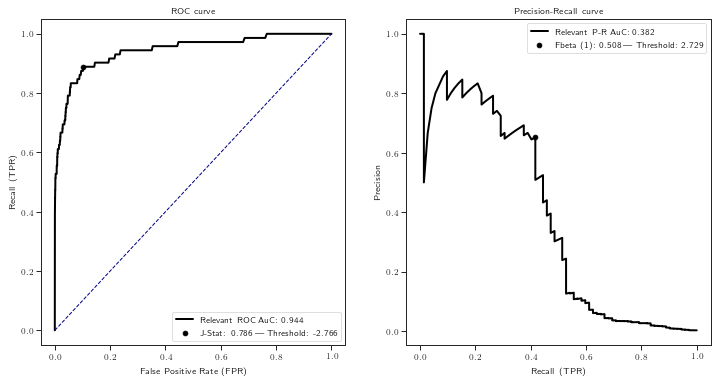

In [15]:
valid_threshold_moving_report = os.path.join(params.RESULTS_DIR, "figures", f"{params.CATEGORY_LEVEL}_{params.TASK}_{params.SCENARIO}_{params.MODEL_NAME}_valid_threshold.pdf")
valid_eval_scores, best_roc_threshold, best_pr_threshold = evaluation.threshold_moving_report(valid_labels, valid_model_outputs, export_path=valid_threshold_moving_report, beta=1)

#results.log_experiment(train_eval_scores, prefix="valid")
results.log_experiment({"epochs": params.EPOCHS})
results.log_experiment({ "best_pr_threshold": best_pr_threshold.values(), "best_roc_threshold": best_roc_threshold.values()}, prefix="valid")
valid_eval_scores

Using threshold values dict_values([2.728515625])
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     39007
        True       0.64      0.40      0.50        72

    accuracy                           1.00     39079
   macro avg       0.82      0.70      0.75     39079
weighted avg       1.00      1.00      1.00     39079



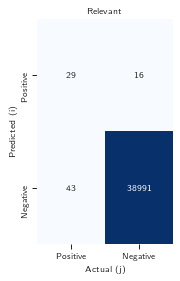

,ROC AuC,PR AuC,F1,Report,CMS
0,0.943689,0.382223,0.495726,"{""1"": {""precision"": 0.6444444444444445, ""recal...","[[[29, 16], [43, 38991]]]"


In [16]:
valid_evaluation_report = os.path.join(params.RESULTS_DIR, "figures", f"{params.CATEGORY_LEVEL}_{params.TASK}_{params.SCENARIO}_{params.MODEL_NAME}_valid_evaluation.pdf")
valid_eval_scores = evaluation.test_evaluation_report(valid_labels, valid_model_outputs, best_pr_threshold.values(), export_path=valid_evaluation_report)
results.log_experiment(valid_eval_scores, prefix="valid")
valid_eval_scores

# Model test

In [17]:
should_test = True
if should_test:
  # test the model
  test_result, test_model_outputs, test_wrong_predictions = model.eval_model(
      test_df,
      # fbeta=lambda truth, preds: sklearn.metrics.fbeta_score(truth, (preds > best_pr_threshold.values()), beta=3),
      roc_auc=lambda truth, preds: sklearn.metrics.roc_auc_score(truth, preds, average=params.AVERAGING_STRATEGY),
      pr_auc=lambda truth, preds: sklearn.metrics.average_precision_score(truth, preds, average=params.AVERAGING_STRATEGY)
  )
  test_result

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/40975 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/5122 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.36157703380514444, 'tp': 57, 'tn': 40682, 'fp': 196, 'fn': 40, 'auroc': 0.9679938998770795, 'auprc': 0.48839098811775805, 'roc_auc': 0.7914170554271878, 'pr_auc': 0.13336689812884014, 'eval_loss': 0.022762642787452693}


Using threshold values dict_values([2.728515625])
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     40878
        True       0.69      0.42      0.53        97

    accuracy                           1.00     40975
   macro avg       0.85      0.71      0.76     40975
weighted avg       1.00      1.00      1.00     40975



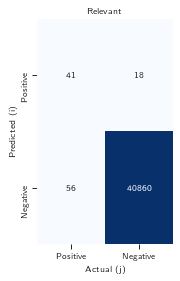

In [18]:
if should_test:
  test_evaluation_report = os.path.join(params.RESULTS_DIR, "figures", f"{params.CATEGORY_LEVEL}_{params.TASK}_{params.SCENARIO}_{params.MODEL_NAME}_test_evaluation.pdf")
  test_eval_scores = evaluation.test_evaluation_report(test_labels, test_model_outputs, best_pr_threshold.values(), export_path=test_evaluation_report)
  results.log_experiment(test_eval_scores, prefix="test")
  test_eval_scores

Using threshold values dict_values([2.728515625])
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     40878
        True       0.69      0.42      0.53        97

    accuracy                           1.00     40975
   macro avg       0.85      0.71      0.76     40975
weighted avg       1.00      1.00      1.00     40975



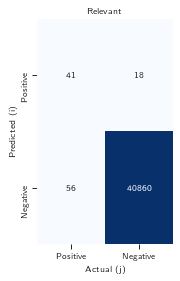

In [21]:
if should_test:
  test_evaluation_report = os.path.join(params.RESULTS_DIR, "figures", f"{params.CATEGORY_LEVEL}_{params.TASK}_{params.SCENARIO}_{params.MODEL_NAME}_test_evaluation.pdf")
  test_eval_scores = evaluation.test_evaluation_report(test_labels, test_model_outputs, best_pr_threshold.values(), export_path=test_evaluation_report)
  results.log_experiment(test_eval_scores, prefix="test")
  test_eval_scores